# Mass Recalibration in CoreMS

This notebook applies CoreMS mass recalibration to a test sample

- Section 1 - Load Dataset
- Section 2 - Calibrate with Reference Masses
- Section 3 - Recalibrate Based on Formula Assignments


### Section 1 - Load Dataset

#### Import dependencies


In [ ]:
import os
import sys
from dotenv import load_dotenv
from pathlib import Path

# Import CoreMS modules for reading Bruker ICR data and setting MS Parameters
# as well as calibration and formula searches
from corems.transient.input.brukerSolarix import ReadBrukerSolarix
from corems.encapsulation.factory.parameters import MSParameters
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas

# Import a plotting library for visualisation
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns

sys.path.append("../../")

#### Load environment variables 
This includes the url to the formula database.

In [ ]:
# Load environment variables from .env file
load_dotenv()

# Build database URL from environment variables
db_url = os.getenv("COREMS_DATABASE_URL")

In [ ]:
data_dir = Path.cwd() / "data" / "user_data"
print(data_dir)

/home/corems/data/user_data


In [ ]:
filepaths = list(data_dir.iterdir())
for idx, filepath in enumerate(filepaths):
    print(f"{idx}: {filepath}")

0: /home/corems/data/user_data/1p5_NegESI_SRFA_AfterSW28_sum50_ABS_3sigma.pks
1: /home/corems/data/user_data/2020September23NegESI_PFAS_AFFF_1_10000_sum250_Rephased.pks
2: /home/corems/data/user_data/2020September23PosESI_PFAS_AFFF_1_10000_sum250_Rephased.pks
3: /home/corems/data/user_data/2021May20_SRFA_Sum568_6p3s_1E6_6sigma.pks
4: /home/corems/data/user_data/2023July28_NegESI_Guardian_AFFFC_wSRFA_4s_3E6_sum150_3sigma.pks
5: /home/corems/data/user_data/2023July28_NegESI_Guardian_AFFFC_wSRFA_4s_8E5_sum150_3sigma.pks
6: /home/corems/data/user_data/2023July28_NegESI_Jacobs3M_AFFF_wSRFA_4s_8E5_sum100_3sigma.pks
7: /home/corems/data/user_data/2023July28_NegESI_PetersonBucket_AFFF_wSRFA_4s_3E6_sum100_3sigma.pks
8: /home/corems/data/user_data/2024March21_NegESI_Angus_Alcoseal_106004E_sum250_3sigma.pks
9: /home/corems/data/user_data/2024March21_NegESI_Angus_Alcoseal_1060_24_sum250_3sigma.pks
10: /home/corems/data/user_data/2024March21_NegESI_Angus_Alcoseal_1061_01_02_sum250_3sigma.pks
11: /h

In [ ]:
datafile = filepaths[19]
print(f"Selected file: {datafile}")

Selected file: /home/corems/data/user_data/NEG_ESI_SRFA_Auto.d


#### Read the designated file
**NOTE:** I had to change the transient filename in the .d directory from `fid_f` to `fid` for a file exported by the scimaX instrument.  We may need to revise CoreMS to look for `fid_f` as an alternative.

In [185]:
# Initiate the bruker reader object
bruker_reader = ReadBrukerSolarix(datafile)

# Set the noise thresholding method
MSParameters.mass_spectrum.noise_threshold_method = "log"
MSParameters.mass_spectrum.noise_threshold_log_nsigma = 10


# Process the spectrum and return the mass spectrum object
mass_spectrum = bruker_reader.get_transient().get_mass_spectrum(
    plot_result=False, auto_process=True
)
print("There were " + str(len(mass_spectrum)) + " peaks detected.")

There were 10082 peaks detected.


#### Assign Formulas without Calibration
Now we will attempt to do formula assignment on these data before any recalibration


In [187]:
# Set some formula search rules - CHO only
mass_spectrum.molecular_search_settings.min_ppm_error = -7.5
mass_spectrum.molecular_search_settings.max_ppm_error = 7.5
mass_spectrum.molecular_search_settings.usedAtoms["C"] = (1, 90)
mass_spectrum.molecular_search_settings.usedAtoms["H"] = (4, 200)
mass_spectrum.molecular_search_settings.usedAtoms["N"] = (0, 1)
mass_spectrum.molecular_search_settings.usedAtoms["O"] = (1, 25)
mass_spectrum.molecular_search_settings.usedAtoms["S"] = (0, 1)
mass_spectrum.molecular_search_settings.isProtonated = True

# Set the database URL for formula searching 
mass_spectrum.molecular_search_settings.url_database = db_url
# If you do not have Postgres in a Docker container, you would set that to = None, e.g.
#         mass_spectrum.molecular_search_settings.url_database = None

# Now search for molecular formulas
SearchMolecularFormulas(mass_spectrum, first_hit=True).run_worker_mass_spectrum()

# How many peaks were assigned
mass_spectrum.percentile_assigned()


'runworker'  215.90 ms


Loading molecular formula database: 87885it [00:09, 9562.74it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 25}, (de)protonated : 100%|██████████| 100/100 [00:06<00:00, 15.71it/s]


'run_molecular_formula'  15996.55 ms
9162 assigned peaks and 920 unassigned peaks , total  = 90.87 %, relative abundance = 97.66 %


(9162, 920, 90.8748264233287, 97.65532489862959)

In [ ]:
# Lets visualise the assignments
# First export to a dataframe:
ms_df = mass_spectrum.to_dataframe()
ms_df.sort_values(by="Peak Height", ascending=False).head(n=10)

,Index,m/z,Calibrated m/z,Calculated m/z,Peak Height,Peak Area,Resolving Power,S/N,Ion Charge,m/z Error (ppm),...,Formula KMD,C,H,O,N,S,13C,18O,33S,34S
942,1256,311.168826,311.168629,311.168639,7.372476e+08,249141.204968,931530.516786,2540.286607,-1,-0.035263,...,-0.8212,17.0,28.0,3.0,NaN,1.0,NaN,NaN,NaN,NaN
1174,1551,325.184452,325.184234,325.184290,5.925589e+08,224650.629998,891184.657103,2033.207003,-1,-0.169961,...,-0.8212,18.0,30.0,3.0,NaN,1.0,NaN,NaN,NaN,NaN
1168,1545,325.093086,325.092869,325.092891,3.731656e+08,113664.312149,891435.127488,1279.476057,-1,-0.069108,...,-0.7299,15.0,18.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
1464,1909,341.088039,341.087799,341.087806,3.675901e+08,149694.979882,849632.581205,1263.032634,-1,-0.018451,...,-0.7069,15.0,18.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
2007,2563,367.103719,367.103441,367.103456,3.348499e+08,122237.510650,789420.965547,1134.151753,-1,-0.040945,...,-0.6935,17.0,20.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
1703,2210,353.088052,353.087794,353.087806,3.311237e+08,152355.105920,820937.297376,1152.372843,-1,-0.032530,...,-0.6935,16.0,18.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
1419,1854,339.072380,339.072143,339.072156,3.276194e+08,108632.182227,854870.990851,1122.152499,-1,-0.037073,...,-0.6935,15.0,16.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
2047,2610,369.082992,369.082711,369.082720,3.240439e+08,162310.388142,785360.687684,1107.042327,-1,-0.025882,...,-0.6706,16.0,18.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
1752,2268,355.103689,355.103429,355.103456,3.230605e+08,142294.376965,816277.824832,1107.264535,-1,-0.076056,...,-0.7069,16.0,20.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
1693,2200,353.051653,353.051395,353.051420,3.218752e+08,102583.923202,821022.306281,1094.598655,-1,-0.070834,...,-0.6572,15.0,14.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN


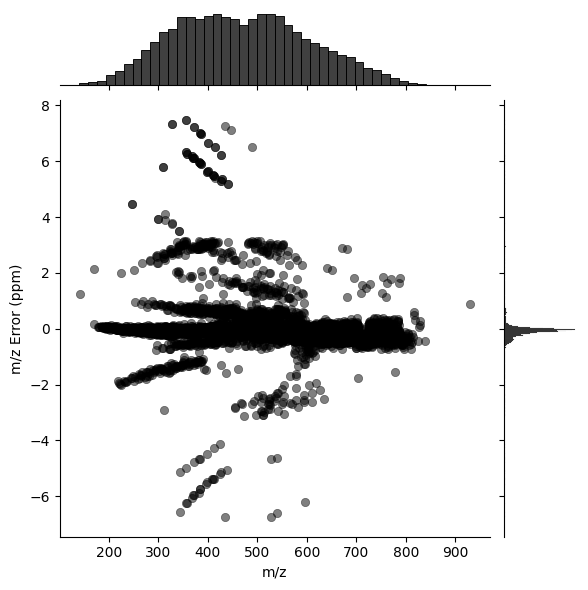

In [ ]:
# Now plot the m/z error vs m/z
g = sns.jointplot(
    x="m/z",
    y="m/z Error (ppm)",
    data=ms_df,
    color="k",
    joint_kws={"edgecolor": None, "alpha": 0.5},
)


### Section 2.  Calibrate with Reference Masses
Next, we will load the reference masses and calibrate.


In [ ]:
# Define the location of our reference mass list
# refmasslist = "Hawkes_neg.ref"
ref_data_path = Path.cwd() / "data/reference_masses"
refmasslist = ref_data_path / "Hawkes_neg.ref"
print(refmasslist)

/home/corems/data/reference_masses/Hawkes_neg.ref


In [ ]:
# Define the mass calibration settings:
mass_spectrum.settings.calib_sn_threshold = 10
mass_spectrum.settings.max_calib_ppm_error = 3
mass_spectrum.settings.min_calib_ppm_error = -3
mass_spectrum.settings.calib_pol_order = 2

MzDomainCalibration(mass_spectrum, refmasslist).run()

/home/corems/corems/mass_spectrum/calc/Calibration.py:69: UserWarning: Warning: calibrating spectra which have already been assigned may yield erroneous results
  warnings.warn(


MS Obj loaded - 10082 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
737 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.156 ppm
minimize function performed 410 fn evals and 7 iterations


In [ ]:
# Clear previous formula assignments
mass_spectrum.clear_molecular_formulas()

# Update threshold for assignments
mass_spectrum.molecular_search_settings.min_ppm_error = -0.75
mass_spectrum.molecular_search_settings.max_ppm_error = 0.75

# Redo the CHO search
SearchMolecularFormulas(mass_spectrum, first_hit=True).run_worker_mass_spectrum()

mass_spectrum.percentile_assigned()

'runworker'  225.62 ms


Loading molecular formula database: 87885it [00:10, 8560.70it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 25}, (de)protonated : 100%|██████████| 100/100 [00:09<00:00, 10.92it/s]


'run_molecular_formula'  19841.50 ms
7464 assigned peaks and 2618 unassigned peaks , total  = 74.03 %, relative abundance = 92.81 %


(7464, 2618, 74.03292997421147, 92.811417667863)

In [ ]:
# Lets visualise the assignments
# First export to a dataframe:
ms_df = mass_spectrum.to_dataframe()
ms_df.sort_values(by="Peak Height", ascending=False).head(n=10)

,Index,m/z,Calibrated m/z,Calculated m/z,Peak Height,Peak Area,Resolving Power,S/N,Ion Charge,m/z Error (ppm),...,Formula KMD,C,H,O,N,S,13C,18O,33S,34S
770,1256,311.168826,311.168643,311.168639,7.372476e+08,249141.832321,931530.516786,2540.286607,-1,0.010637,...,-0.8212,17.0,28.0,3.0,NaN,1.0,NaN,NaN,NaN,NaN
940,1551,325.184452,325.184251,325.184290,5.925589e+08,224651.150366,891184.657103,2033.207003,-1,-0.118454,...,-0.8212,18.0,30.0,3.0,NaN,1.0,NaN,NaN,NaN,NaN
936,1545,325.093086,325.092885,325.092891,3.731656e+08,113664.575571,891435.127488,1279.476057,-1,-0.017636,...,-0.7299,15.0,18.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
1146,1909,341.088039,341.087819,341.087806,3.675901e+08,149695.292371,849632.581205,1263.032634,-1,0.039143,...,-0.7069,15.0,18.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
1526,2563,367.103719,367.103465,367.103456,3.348499e+08,122237.720056,789420.965547,1134.151753,-1,0.026067,...,-0.6935,17.0,20.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
1312,2210,353.088052,353.087816,353.087806,3.311237e+08,152355.397661,820937.297376,1152.372843,-1,0.029484,...,-0.6935,16.0,18.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
1115,1854,339.072380,339.072162,339.072156,3.276194e+08,108632.412144,854870.990851,1122.152499,-1,0.019764,...,-0.6935,15.0,16.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
1553,2610,369.082992,369.082736,369.082720,3.240439e+08,162310.661590,785360.687684,1107.042327,-1,0.041823,...,-0.6706,16.0,18.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
1346,2268,355.103689,355.103451,355.103456,3.230605e+08,142294.645308,816277.824832,1107.264535,-1,-0.013312,...,-0.7069,16.0,20.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
1306,2200,353.051653,353.051417,353.051420,3.218752e+08,102584.119702,821022.306281,1094.598655,-1,-0.008833,...,-0.6572,15.0,14.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN


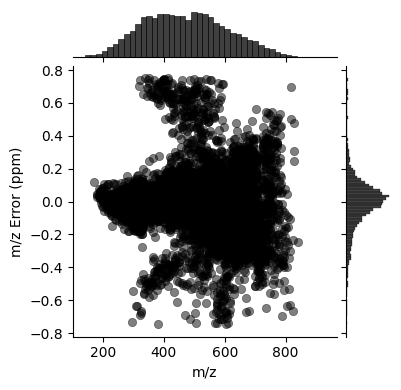

In [ ]:
# Now plot the m/z error vs m/z
g = sns.jointplot(
    x="m/z",
    y="m/z Error (ppm)",
    data=ms_df,
    color="k",
    height=4,
    joint_kws={"edgecolor": None, "alpha": 0.5},
)


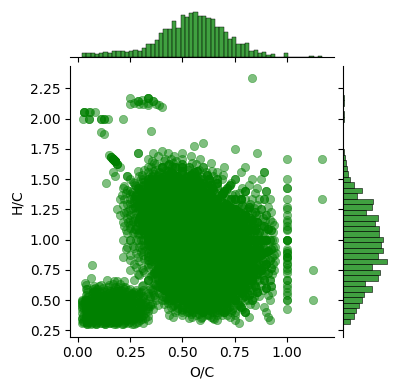

In [ ]:
f = sns.jointplot(
    x="O/C",
    y="H/C",
    data=ms_df,
    color="green",
    height=4,
    joint_kws={"edgecolor": None, "alpha": 0.5},
)

### Section 3 - Automatic recalibration based on assignments


In [167]:
# Import the class for automatic recalibration based on assignments
from corems.mass_spectrum.calc.AutoRecalibration import HighResRecalibration


In [168]:
# This class is initialised with a few options, you must pass the mass spectrum object first.
# plot= true - will plot the models for the automatic determination of the error boundaries.
# docker - uses docker for formula assignment (else, uses sqlite).
# ppmFWHMprior - estimate the spread of mass errors in the raw data.
# ppmRangeprior - estimate possible range of mass error medians (e.g. 15 = +-7.5).
autorecaler = HighResRecalibration(
    mass_spectrum, plot=True, docker=True, ppmFWHMprior=3, ppmRangeprior=15
)

'runworker'  937.17 ms


Loading molecular formula database: 25098it [00:01, 12986.05it/s]
Started molecular formula search for class {"O": 23}, (de)protonated : 100%|██████████| 23/23 [00:00<00:00, 31.32it/s]


'run_molecular_formula'  3731.75 ms


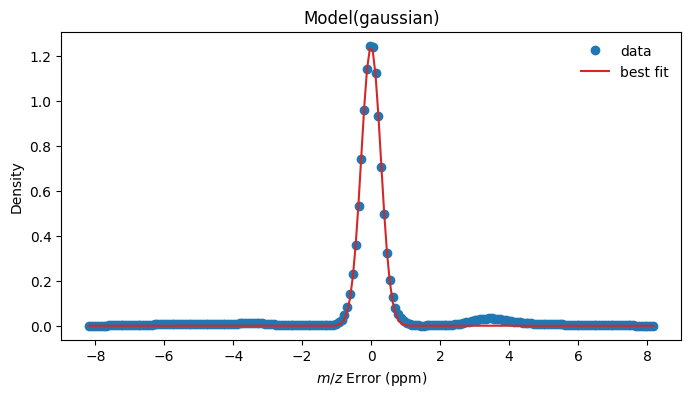

In [169]:
auto_cal_boundaries = autorecaler.determine_error_boundaries()

In [170]:
print(
    f"Raw error center: {auto_cal_boundaries[0]:.2f} ppm, \nRaw error standard FWHM: {auto_cal_boundaries[1]:.2f} ppm, \nSuggested bounds based on mean error +- fwhm: {auto_cal_boundaries[2][0]:.2f} to {auto_cal_boundaries[2][1]:.2f} ppm"
)

Raw error center: -0.00 ppm, 
Raw error standard FWHM: 0.67 ppm, 
Suggested bounds based on mean error +- fwhm: -0.67 to 0.66 ppm


In [171]:
# Now recalibrate the data based on those bounds:
# Define the mass calibration settings:
# Use the original/legacy method for matching reference masses.
MSParameters.mass_spectrum.calibration_ref_match_method = "legacy"
mass_spectrum.settings.calib_sn_threshold = 10
mass_spectrum.settings.max_calib_ppm_error = max(auto_cal_boundaries[2])
mass_spectrum.settings.min_calib_ppm_error = min(auto_cal_boundaries[2])
mass_spectrum.settings.calib_pol_order = 2

MzDomainCalibration(mass_spectrum, refmasslist).run()

/home/corems/corems/mass_spectrum/calc/Calibration.py:69: UserWarning: Warning: calibrating spectra which have already been assigned may yield erroneous results
  warnings.warn(


MS Obj loaded - 10082 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
854 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.146 ppm
minimize function performed 75 fn evals and 1 iterations


In [173]:
# And now assign the recalibrated data
# Update threshold for assignment
mass_spectrum.molecular_search_settings.min_ppm_error = -0.75
mass_spectrum.molecular_search_settings.max_ppm_error = 0.75
mass_spectrum.molecular_search_settings.usedAtoms["C"] = (1, 90)
mass_spectrum.molecular_search_settings.usedAtoms["H"] = (4, 200)
mass_spectrum.molecular_search_settings.usedAtoms["O"] = (1, 25)
mass_spectrum.molecular_search_settings.usedAtoms["N"] = (0, 4)
mass_spectrum.molecular_search_settings.usedAtoms["S"] = (0, 2)
mass_spectrum.molecular_search_settings.isProtonated = True

# Redo the CHO search
SearchMolecularFormulas(mass_spectrum, first_hit=True).run_worker_mass_spectrum()

mass_spectrum.percentile_assigned()

'runworker'  668.46 ms


Loading molecular formula database: 245423it [00:30, 8051.41it/s] 
Started molecular formula search for class {"N": 3, "S": 2, "O": 25}, (de)protonated : 100%|██████████| 300/300 [00:10<00:00, 28.73it/s]
Loading molecular formula database: 62948it [00:09, 6432.39it/s] 
Started molecular formula search for class {"N": 4, "S": 2, "O": 25}, (de)protonated : 100%|██████████| 75/75 [00:02<00:00, 29.43it/s]


'run_molecular_formula'  54416.47 ms
8287 assigned peaks and 1795 unassigned peaks , total  = 82.20 %, relative abundance = 94.97 %


(8287, 1795, 82.1959928585598, 94.96624603530893)

In [175]:
# Lets visualise the assignments
# First export to a dataframe:
ms_df = mass_spectrum.to_dataframe()
ms_df.sort_values(by="Peak Height", ascending=False).head(n=10)

,Index,m/z,Calibrated m/z,Calculated m/z,Peak Height,Peak Area,Resolving Power,S/N,Ion Charge,m/z Error (ppm),...,Formula KMD,C,H,O,N,S,13C,18O,33S,34S
806,1256,311.168826,311.168642,311.168639,7.372476e+08,249141.214706,931530.516786,2540.286607,-1,0.009264,...,-0.8212,17.0,28.0,3.0,NaN,1.0,NaN,NaN,NaN,NaN
997,1551,325.184452,325.184251,325.184290,5.925589e+08,224650.643017,891184.657103,2033.207003,-1,-0.119823,...,-0.8212,18.0,30.0,3.0,NaN,1.0,NaN,NaN,NaN,NaN
992,1545,325.093086,325.092885,325.092891,3.731656e+08,113664.318706,891435.127488,1279.476057,-1,-0.019006,...,-0.7299,15.0,18.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
1237,1909,341.088039,341.087819,341.087806,3.675901e+08,149694.991755,849632.581205,1263.032634,-1,0.037776,...,-0.7069,15.0,18.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
1683,2563,367.103719,367.103465,367.103456,3.348499e+08,122237.524609,789420.965547,1134.151753,-1,0.024706,...,-0.6935,17.0,20.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
1434,2210,353.088052,353.087816,353.087806,3.311237e+08,152355.120468,820937.297376,1152.372843,-1,0.028120,...,-0.6935,16.0,18.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
1200,1854,339.072380,339.072162,339.072156,3.276194e+08,108632.190555,854870.990851,1122.152499,-1,0.018397,...,-0.6935,15.0,16.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
1713,2610,369.082992,369.082735,369.082720,3.240439e+08,162310.407128,785360.687684,1107.042327,-1,0.040462,...,-0.6706,16.0,18.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
1474,2268,355.103689,355.103451,355.103456,3.230605e+08,142294.390926,816277.824832,1107.264535,-1,-0.014676,...,-0.7069,16.0,20.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
1426,2200,353.051653,353.051417,353.051420,3.218752e+08,102583.932992,821022.306281,1094.598655,-1,-0.010197,...,-0.6572,15.0,14.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN


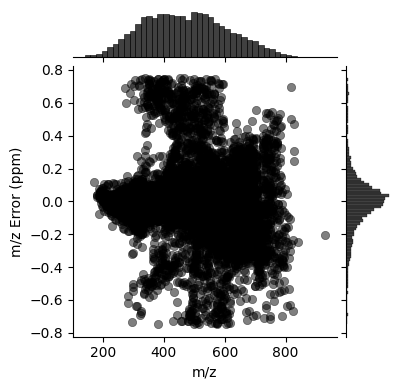

In [176]:
# Now plot the m/z error vs m/z
g = sns.jointplot(
    x="m/z",
    y="m/z Error (ppm)",
    data=ms_df,
    color="k",
    height=4,
    joint_kws={"edgecolor": None, "alpha": 0.5},
)

In [177]:
from corems.molecular_id.factory.classification import HeteroatomsClassification

mass_spectrum_by_classes = HeteroatomsClassification(
    mass_spectrum, choose_molecular_formula=True
)


<Axes: xlabel='$\t{m/z}$', ylabel='Abundance'>

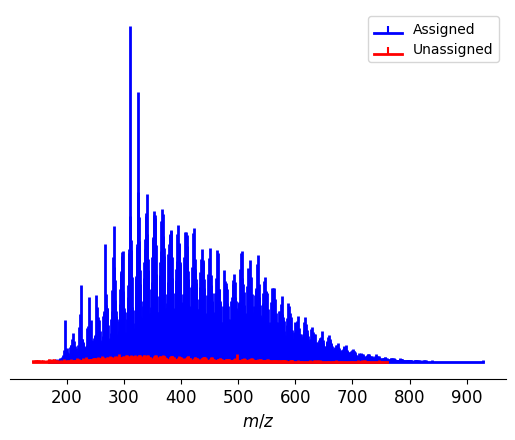

In [178]:
mass_spectrum_by_classes.plot_ms_assigned_unassigned()


<Axes: title={'center': 'Van Krevelen Diagram - All Assigned Classes'}, xlabel='O/C', ylabel='H/C'>

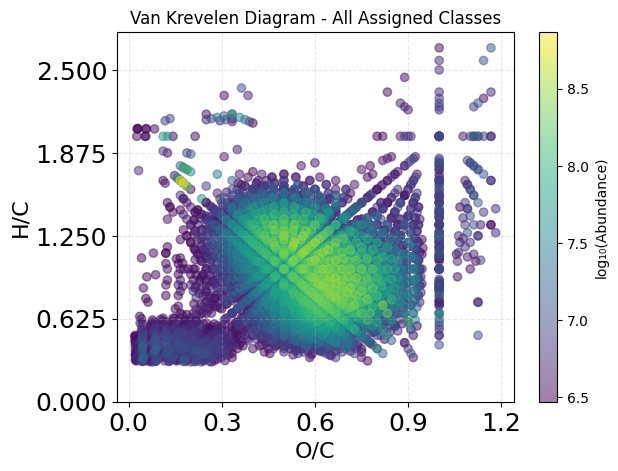

In [179]:
mass_spectrum_by_classes.plot_van_krevelen(log_abundance=True, max_oc=1.2)